## Import Libraries

In [1]:
import pandas as pd
import pandas_profiling as pdpf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow
print(tensorflow.__version__)
# from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import tensorflow.keras.backend as K
from RegscorePy import *
print("GPU Available: ", tensorflow.test.is_gpu_available())



2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using TensorFlow backend.


GPU Available:  True


## Helper Methods

In [2]:
def write_dict_to_json(path, content):
    with open(path + '.json', 'w') as file:
        file.write(json.dumps(content, ensure_ascii=False))
    
def write_str_to_txt(path, content):
    text_file = open(path + ".txt", "w")
    text_file.write(content) 
    text_file.close()

def plot_actual_vs_predicted(actual_column, predicted_column):
    plt.plot(list(range(1, len(actual_column) + 1)), actual_column, color='b', label='actual')
    plt.plot(list(range(1, len(actual_column) + 1)), predicted_column, color='r', label='predicted')
    plt.legend(loc='best')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted')
    plt.close()
    
def plot_actual_vs_predicted_scatter_bisector(actual_column, predicted_column):
    fig, ax = plt.subplots()
    ax.scatter(actual_column, predicted_column)
    ax.plot([actual_column.min(), actual_column.max()], [predicted_column.min(), predicted_column.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.suptitle('actual vs. predicted')
    plt.savefig(output_path + 'actual_vs_predicted_scatter_plot')
    plt.close()
    
    
def generate_lags_for(df, column, lags_count): 
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def error_metrics(y_test, y_pred, nb_columns, nb_param):
    n = len(y_test)
    #convert to float for it to work for AIC and BIC data should all be of the same format i.e float not mix of types
    y_test_f =  [float(item) for item in y_test.values]
    y_predict_f =  [float(item) for item in y_pred]
    test_scores = {}
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test_f, y_predict_f)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    re = (mse_score / np.mean(y_pred)) * 100
    accuracy = 100 - np.mean(mape_score)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    r2 = str(round(r2_Score, 2))
    adjusted_r2 = str(round(adjusted_r2, 2))
    mae = str(round(mae_score, 2))
    mse = str(round(mse_score, 2))
    rmse = str(round(rmse_score, 2))
    re = str(round(re, 2))
    spearman = str(round(spearman_corr, 2))
    mape = str(round(mape_score, 2)) + "%"
    accuracy = str(round(accuracy, 2)) + "%"
    
    nmi = 1
#     normalized_mutual_info_score(y_test_n, y_pred)
    
#     nmi = 0
#     inm = drv.information_mutual_normalised(y_test, y_pred)
#     array_sum = np.sum(inm)
#     inm_has_nan = np.isnan(array_sum)
#     if inm_has_nan:
#         nmi = "NaN"
#     else:
#         nmi = str(inm)


    def calculate_aic(n, mse, num_params):
        aic = n * log(mse) + 2 * num_params
        return aic

    def calculate_bic(n, mse, num_params):
        bic = n * log(mse) + num_params * log(n)
        return bic

    aic = str(round(calculate_aic(len(y_test), mse_score, nb_param), 2))
    bic = str(round(calculate_bic(len(y_test), mse_score, nb_param), 2))

    test_scores["average output"] =  str(y_test.mean())
    test_scores["R2"] = r2
    test_scores["Adjusted R2"] = adjusted_r2
    test_scores["MAE"] = mae
    test_scores["MSE"] = mse
    test_scores["RMSE"] = rmse
    test_scores["Relative Error"] = re
    test_scores["Spearman"] = spearman
    test_scores["MAPE"] = mape
    test_scores["Accuracy"] = accuracy
    test_scores["Information Mutal Normalised"] = nmi
    test_scores["AIC"] = aic
    test_scores["BIC"] = bic
    return test_scores

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df

## Get the data

In [3]:
input_path = "gs://agriculture-sara/Data sets/Experiments/Experiment Details.xlsx"
output_path = "Daily Experiments/Base/Manual All/"
df_experiment = pd.read_excel(input_path, "Daily")
df_experiment

Name       Category Sub Category  \
0                  All Sites   Manual Bowen      Cleaned   
1            Ameriflux Sites   Manual Bowen      Cleaned   
2             Euroflux Sites   Manual Bowen      Cleaned   
3   Ameriflux Euroflux Sites   Manual Bowen      Cleaned   
4                  All Sites   Manual Bowen      Imputed   
5            Ameriflux Sites   Manual Bowen      Imputed   
6             Euroflux Sites   Manual Bowen      Imputed   
7   Ameriflux Euroflux Sites   Manual Bowen      Imputed   
8                  All Sites  Library Bowen      Cleaned   
9            Ameriflux Sites  Library Bowen      Cleaned   
10            Euroflux Sites  Library Bowen      Cleaned   
11                 All Sites    Library Ebr      Cleaned   
12           Ameriflux Sites    Library Ebr      Cleaned   
13            Euroflux Sites    Library Ebr      Cleaned   

                                          Description    Model name  
0   Trained and tested on all the sites with dropp...   All_M_Cl.h5  
1   Trained and tested on Ameriflux sites with dro...    Am_M_Cl.h5  
2   Trained and tested on Euroflux Sites with drop...    Ef_M_Cl.h5  
3   Trained on Ameriflux Sites and tested on Eurof...  AmEf_M_Cl.h5  
4   Trained and tested on all the sites with imput...   All_M_Im.h5  
5   Trained and tested on Ameriflux sites with imp...    Am_M_Im.h5  
6   Trained and tested on Euroflux Sites with impu...    Ef_M_Im.h5  
7   Trained on Ameriflux Sites and tested on Eurof...  AmEf_M_Im.h5  
8   Trained and tested on all the sites with dropp...  All_LB_Cl.h5  
9   Trained and tested on Ameriflux sites with dro...   Am_LB_Cl.h5  
10  Trained and tested on Euroflux Sites with drop...   Ef_LB_Cl.h5  
11  Trained and tested on all the sites with dropp...  All_LE_Cl.h5  
12  Trained and tested on Ameriflux sites with dro...   Am_LE_Cl.h5  
13  Trained and tested on Euroflux Sites with drop...   Ef_LE_Cl.h5

In [4]:
input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')

# df = df[df["Site Id"].str.startswith('US-')]

columnsToDrop = ['Date','Year','Month','Day',
                 'Climate', 'Vegetation', 'Latitude', 'Longitude',
                 'G','G-1','G-2','G-3','G-4','G-5',
                 'Climate_1', 'Climate_2', 'Climate_3',
                 'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                 'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                 'Longitude_5', 'Longitude_6',
                 'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                 'H_bowen_corr-5', 'C_BOWENS',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                 'LE', 'LE_bowen_corr',
                 'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                 'Elevation(m)_5', 'Elevation(m)_6',
                 'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']


# columnsToDrop = ['Date','Year','Month','Day','Latitude','Longitude',
#                  'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
#                  'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
#                  'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
#                  'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr','LE_ebr_corr(mm)',
#                  'ET_bowen','ET_bowen_corr','LE_bowen_corr(mm)','ET_ebr','ET_ebr_corr',
#                  'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
#                  'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
#                  'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
#                  'Climate_2','Climate_3', 'Latitude_1',
#                  'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
#                  'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
#                  'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
#                  'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'SW_IN']


df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

output_column = "LE_bowen_corr(mm)"
df = df[df[output_column].between(1, 15)]
df.head()

Site Id  Site Id_1  Site Id_2  Site Id_3  Site Id_4  Site Id_5  Site Id_6  \
5  FI-Jok          1          0          1          0          1          0   
6  FI-Jok          1          0          1          0          1          0   
7  FI-Jok          1          0          1          0          1          0   
8  FI-Jok          1          0          1          0          1          0   
9  FI-Jok          1          0          1          0          1          0   

   Month_1  Month_2  Month_3  ...  EEflux NDVI-2  EEflux NDVI-3  \
5        0        1        0  ...          0.402          0.413   
6        0        1        0  ...          0.453          0.402   
7        0        1        0  ...          0.481          0.453   
8        0        1        0  ...          0.449          0.481   
9        0        1        0  ...          0.363          0.449   

   EEflux NDVI-4  EEflux NDVI-5  EEflux Albedo  EEflux Albedo-1  \
5          0.316         -0.053          0.122            0.122   
6          0.413          0.316          0.122            0.122   
7          0.402          0.413          0.121            0.122   
8          0.453          0.402          0.121            0.121   
9          0.481          0.453          0.121            0.121   

   EEflux Albedo-2  EEflux Albedo-3  EEflux Albedo-4  EEflux Albedo-5  
5            0.121            0.121            0.110            0.507  
6            0.122            0.121            0.121            0.110  
7            0.122            0.122            0.121            0.121  
8            0.122            0.122            0.122            0.121  
9            0.121            0.122            0.122            0.122  

[5 rows x 51 columns]

In [5]:
lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
df = generate_lags(df, lagsForColumns)
print(df.columns)
print(df.shape)

num_features = df.shape[1]
print(num_features)

Index(['Site Id', 'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4',
       'Site Id_5', 'Site Id_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr(mm)',
       'EEflux LST', 'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3',
       'EEflux LST-4', 'EEflux LST-5', 'EEflux NDVI', 'EEflux NDVI-1',
       'EEflux NDVI-2', 'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5',
       'EEflux Albedo', 'EEflux Albedo-1', 'EEflux Albedo-2',
       'EEflux Albedo-3', 'EEflux Albedo-4', 'EEflux Albedo-5'],
      dtype='object')
(10916, 51)
51


In [6]:
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)

(10911, 51)


## Split data into train, test, validation

In [7]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.2

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    X_valid = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    Y_valid = pd.DataFrame()
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))
    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
#         X = df_site.drop([output_column], axis = 1)
#         Y = df_site[output_column]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))
        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:test_index], ignore_index = True)
        X_valid = X_valid.append(X[test_index:], ignore_index = True)
        
        Y_train = Y_train.append(X[:train_index], ignore_index = False)
        Y_test = Y_test.append(X[train_index:test_index], ignore_index = False)
        Y_valid = Y_valid.append(X[test_index:], ignore_index = False)
    
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
    Y_valid = Y_valid[[output_column]]
    
    X_train = X_train.drop([output_column], axis = 1) 
    X_test = X_test.drop([output_column], axis = 1) 
    X_valid = X_valid.drop([output_column], axis = 1) 
    
    return (X_train, Y_train, X_test, Y_test, X_valid, Y_valid)
    
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_valid shape:", X_valid.shape)
print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape, "Y_valid shape:", Y_valid.shape)

columnToDrop = "Site Id"
X_train.drop([columnToDrop], axis = 1, inplace=True)
X_test.drop([columnToDrop], axis = 1, inplace=True)
X_valid.drop([columnToDrop], axis = 1, inplace=True)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

n_input = X_train.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1

Number of sites: 26
X_train shape: (6536, 50) X_test shape: (2182, 50) X_valid shape: (2193, 50)
Y_train shape: (6536, 1) Y_test shape: (2182, 1) Y_valid shape: (2193, 1)
num of input: 49 num of classes: 1


## Prepare Json for Experiment Information

In [8]:
current_experiment = df_experiment.iloc[0, :]
experiment_info = current_experiment.to_dict()
experiment_info["Input Features"] = list(X_train.columns)
experiment_info["Output Feature"] = str(Y_train.columns[0])
experiment_info["Train Size"] = str(X_train.shape)
experiment_info["Validation Size"] = str(X_valid.shape)
experiment_info["Test Size"] = str(X_test.shape)


sorted_dict = OrderedDict(sorted(experiment_info.items(), key=lambda t: t[0]))
write_dict_to_json(output_path + "experiment_info", sorted_dict)

## Create a keras wrapper model

In [9]:
def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mean_absolute_percentage_error'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    # Compile model
#     model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae', 'accuracy', 'mape'])
#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    return model

## Chapter 20: Model Averging Ensemble

Train on 6536 samples
Epoch 1/400
6536/6536 [==============================] - 1s 185us/sample - loss: 8.2898 - mse: 8.2898 - mae: 2.1953 - accuracy: 0.0000e+00 - mape: 66.3088
Epoch 2/400
6536/6536 [==============================] - 1s 118us/sample - loss: 7.4504 - mse: 7.4504 - mae: 2.0084 - accuracy: 0.0000e+00 - mape: 60.6993
Epoch 3/400
6536/6536 [==============================] - 1s 120us/sample - loss: 7.4219 - mse: 7.4219 - mae: 1.9767 - accuracy: 0.0000e+00 - mape: 58.4451
Epoch 4/400
6536/6536 [==============================] - 1s 118us/sample - loss: 7.4209 - mse: 7.4209 - mae: 1.9565 - accuracy: 0.0000e+00 - mape: 57.1664
Epoch 5/400
6536/6536 [==============================] - 1s 119us/sample - loss: 7.3412 - mse: 7.3412 - mae: 1.9565 - accuracy: 0.0000e+00 - mape: 57.0365
Epoch 6/400
6536/6536 [==============================] - 1s 118us/sample - loss: 7.3121 - mse: 7.3121 - mae: 1.9411 - accuracy: 0.0000e+00 - mape: 56.4816
Epoch 7/400
6536/6536 [=========================

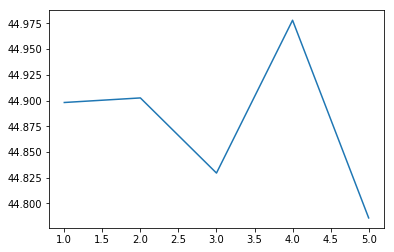

Scores Mean: 44.879, Standard Deviation: 0.066


In [15]:
# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=n_input, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.3))
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'accuracy', 'mape'])
    # fit model
    model.fit(trainX, trainy, epochs=400, verbose=1)
    return model


#make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    result = np.mean(yhats)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy): # select a subset of members
    subset = members[:n_members]
    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate mape
    return np.asarray(np.abs(( np.array(testy) - np.array(yhat)) / np.array(testy)), dtype=np.float64).mean() * 100


# fit all models
n_members = 5
members = [fit_model(X_train_scaled, Y_train) for _ in range(n_members)] # evaluate different numbers of ensembles
scores = list()
for i in range(1, n_members+1):
    score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    print('> %.3f' % score)
    scores.append(score)
    
# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
plt.plot(x_axis, scores)
plt.show()

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (mean(scores), std(scores)))

## Chapter 21: Contribute Proportional to Trust with Weighted Average Ensemble

Train on 6536 samples
Epoch 1/300
6536/6536 [==============================] - 1s 147us/sample - loss: 8.1332 - mape: 66.3015
Epoch 2/300
6536/6536 [==============================] - 1s 91us/sample - loss: 7.5814 - mape: 60.9848
Epoch 3/300
6536/6536 [==============================] - 1s 90us/sample - loss: 7.4456 - mape: 58.5932
Epoch 4/300
6536/6536 [==============================] - 1s 94us/sample - loss: 7.3032 - mape: 56.8786
Epoch 5/300
6536/6536 [==============================] - 1s 91us/sample - loss: 7.1069 - mape: 56.2649
Epoch 6/300
6536/6536 [==============================] - 1s 92us/sample - loss: 7.1309 - mape: 55.2581
Epoch 7/300
6536/6536 [==============================] - 1s 94us/sample - loss: 7.0272 - mape: 55.1012
Epoch 8/300
6536/6536 [==============================] - 1s 92us/sample - loss: 7.0389 - mape: 54.2795
Epoch 9/300
6536/6536 [==============================] - 1s 93us/sample - loss: 7.1560 - mape: 54.2233
Epoch 10/300
6536/6536 [==========================

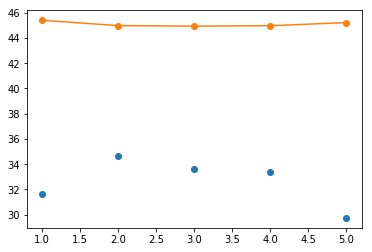

In [31]:
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=n_input, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.3))
    model.compile(loss='mse', optimizer='adam', metrics=['mape'])
    # fit model
    model.fit(trainX, trainy, epochs=300, verbose=1)
    return model

#make an ensemble prediction
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    result = np.mean(yhats)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy): # select a subset of members
    subset = members[:n_members]
    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate mape
    return np.asarray(np.abs(( np.array(testy) - np.array(yhat)) / np.array(testy)), dtype=np.float64).mean() * 100


# fit all models
n_members = 5
members = [fit_model(X_train_scaled, Y_train) for _ in range(n_members)]
# evaluate different numbers of ensembles on hold out set 
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    _, single_score = members[i-1].evaluate(X_test_scaled, Y_test, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
    
# summarize average accuracy of a single final model
print('MAPE %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='o')
plt.show()

## Chapter 22: Fit Models on Different Samples with Resampling Ensembles

In [39]:
##Random Split
import numpy

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
# define model
    model = Sequential()
    model.add(Dense(64, input_dim=n_input, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.add(Dropout(0.3))
    model.compile(loss='mse', optimizer='adam', metrics=['mape'])
    # fit model
    model.fit(trainX, trainy, validation_data=(testX, testy), epochs=300, verbose=1)
     # evaluate the model
    _, test_mape = model.evaluate(testX, testy, verbose=1)
    return model, test_mape

#make an ensemble prediction
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    result = np.mean(yhats)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy): # select a subset of members
    subset = members[:n_members]
    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate mape
    return np.asarray(np.abs(( np.array(testy) - np.array(yhat)) / np.array(testy)), dtype=np.float64).mean() * 100

X = df
train_index = int(X.shape[0] * TRAIN_RATIO)
test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

X_train = X_train.append(X[:train_index], ignore_index = True)
X_test = X_test.append(X[train_index:test_index], ignore_index = True)

Y_train = X_train[[output_column]]
Y_test = X_test[[output_column]]
    
X_train = X_train.drop([output_column], axis = 1) 
X_test = X_test.drop([output_column], axis = 1) 
    
scaler = MinMaxScaler()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
columnToDrop = "Site Id"
X_train.drop([columnToDrop], axis = 1, inplace=True)
X_test.drop([columnToDrop], axis = 1, inplace=True)

# multiple train-test splits
n_splits = 3
scores, members = list(), list()
for _ in range(n_splits):
    # split data
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    # evaluate model
    model, test_mape = evaluate_model(X_train_scaled, Y_train, X_valid_scaled, Y_valid)
    print('>%.3f' % test_mape)
    scores.append(test_mape)
    members.append(model)

X_test_scaled = scaler.transform(X_test)

# summarize expected performance
print('Estimated MAPE %.3f (%.3f)' % (mean(scores), std(scores)))

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()

for i in range(1, n_splits+1):
    ensemble_score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    _, single_score = members[i-1].evaluate(X_test_scaled, Y_test, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# plot score vs number of ensemble members
print('MAPE %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

(57859, 50) (57859, 1)
(28366, 50) (28366, 1)
Train on 46287 samples, validate on 11572 samples
Epoch 1/300
46287/46287 [==============================] - 7s 157us/sample - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 2/300
46287/46287 [==============================] - 6s 119us/sample - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 3/300
46287/46287 [==============================] - 5s 110us/sample - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 4/300
46287/46287 [==============================] - 5s 108us/sample - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 5/300
46287/46287 [==============================] - 5s 108us/sample - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 6/300
46287/46287 [==============================] - 5s 109us/sample - loss: nan - mape: nan - val_loss: nan - val_mape: nan
Epoch 7/300
46287/46287 [==============================] - 5s 109us/sample - loss: nan - mape: nan - val_loss: nan - v

KeyboardInterrupt: 

In [ ]:
## Cross Validation

## Chapter 23: Models from Contiguous Epochs with Horizontal Voting Ensembles

In [10]:
# load models and make predictions using a horizontal voting ensemble
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

# load models from file
def load_all_models(n_start, n_end):
    all_models = list()
    for epoch in range(n_start, n_end):
        # define filename for this ensemble
        filename = 'models/model_' + str(epoch) + '.h5' # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

#make an ensemble prediction
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    result = np.mean(yhats)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy): # select a subset of members
    subset = members[:n_members]
    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate mape
    return np.asarray(np.abs(( np.array(testy) - np.array(yhat)) / np.array(testy)), dtype=np.float64).mean() * 100


def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mean_absolute_percentage_error'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    # Compile model
#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mape'])
    return model


# fit model
n_epochs, n_save_after = 500, 450
# n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
  # fit model for a single epoch
    model = create_model()
    model.fit(X_train_scaled, Y_train, epochs=1, verbose=1)
      # check if we should save the model
    if i >= n_save_after:
        model.save('models/model_' + str(i) + '.h5')
    

# load models in order
members = load_all_models(450, 500)
print('Loaded %d models' % len(members))

# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    # evaluate the i'th model standalone
    _, single_score = members[i-1].evaluate(X_test_scaled, Y_test, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
        
# summarize average accuracy of a single final model
print('MAPE %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

Train on 6536 samples
6536/6536 [==============================] - 4s 616us/sample - loss: 37.8938 - mape: 37.8923
Train on 6536 samples
6536/6536 [==============================] - 1s 217us/sample - loss: 36.2629 - mape: 36.2615
Train on 6536 samples
6536/6536 [==============================] - 1s 215us/sample - loss: 41.6371 - mape: 41.6357
Train on 6536 samples
6536/6536 [==============================] - 1s 215us/sample - loss: 39.6233 - mape: 39.6220
Train on 6536 samples
6536/6536 [==============================] - 1s 212us/sample - loss: 36.8674 - mape: 36.8660
Train on 6536 samples
6536/6536 [==============================] - 1s 210us/sample - loss: 47.2042 - mape: 47.2028
Train on 6536 samples
6536/6536 [==============================] - 2s 255us/sample - loss: 38.2562 - mape: 38.2549
Train on 6536 samples
6536/6536 [==============================] - 1s 214us/sample - loss: 39.7116 - mape: 39.7103
Train on 6536 samples
6536/6536 [==============================] - 1s 213us/samp

OSError: Unable to create file (unable to open file: name = 'models/model_450.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

## Chapter 24: Cyclic Learning Rate and Snapshot Ensembles

In [13]:
# mlp with cosine annealing learning rate schedule on blobs problem
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor
from matplotlib import pyplot

# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles 
        self.lr_max = lrate_max
        self.lrates = list()
    
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (cos(cos_inner) + 1)
    
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)
    
# define model
def fit_model(trainX, trainy, testX, testy, n_epochs, n_cycles):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=n_input, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mape'])
    # fit model
    ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.01)
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=1, callbacks=[ca])
    return (model, history, ca)

# define learning rate callback
n_epochs = 400
n_cycles = n_epochs / 50


X_train, Y_train, X_test, Y_test, X_valid, Y_valid = split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_valid shape:", X_valid.shape)
print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape, "Y_valid shape:", Y_valid.shape)

columnToDrop = "Site Id"
X_train.drop([columnToDrop], axis = 1, inplace=True)
X_test.drop([columnToDrop], axis = 1, inplace=True)
X_valid.drop([columnToDrop], axis = 1, inplace=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

n_input = X_train.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1

# fit model
model, history, ca = fit_model(X_train_scaled, Y_train, X_test_scaled, Y_test, n_epochs, n_cycles)

Number of sites: 26
X_train shape: (6536, 50) X_test shape: (2182, 50) X_valid shape: (2193, 50)
Y_train shape: (6536, 1) Y_test shape: (2182, 1) Y_valid shape: (2193, 1)
num of input: 49 num of classes: 1
Train on 6536 samples, validate on 2182 samples
Epoch 1/400
6536/6536 [==============================] - 1s 172us/sample - loss: 2.7498 - mape: 43.7211 - val_loss: 2.1090 - val_mape: 33.7820
Epoch 2/400
6536/6536 [==============================] - 1s 117us/sample - loss: 2.2776 - mape: 37.9594 - val_loss: 1.8585 - val_mape: 40.7500
Epoch 3/400
6536/6536 [==============================] - 1s 115us/sample - loss: 2.0568 - mape: 35.8738 - val_loss: 1.7474 - val_mape: 36.9737
Epoch 4/400
6536/6536 [==============================] - 1s 115us/sample - loss: 1.9915 - mape: 35.2871 - val_loss: 2.9960 - val_mape: 57.0893
Epoch 5/400
6536/6536 [==============================] - 1s 115us/sample - loss: 1.8434 - mape: 33.6725 - val_loss: 1.6139 - val_mape: 32.3058
Epoch 6/400
6536/6536 [========

Train: 22.893, Test: 32.697


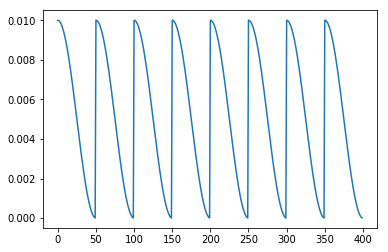

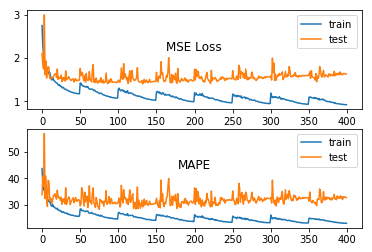

In [14]:
# evaluate the model
_, train_mape = model.evaluate(X_train_scaled, Y_train, verbose=0)
_, test_mape = model.evaluate(X_test_scaled, Y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mape, test_mape))

# plot learning rate
pyplot.plot(ca.lrates)
pyplot.show()

# plot loss learning curves
pyplot.subplot(211)
pyplot.title('MSE Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('MAPE', pad=-40)
pyplot.plot(history.history['mape'], label='train')
pyplot.plot(history.history['val_mape'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
    
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (cos(cos_inner) + 1)
    
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs={}):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max) # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)
    
    # save models at the end of each cycle
    def on_epoch_end(self, epoch, logs={}):
        # check if we can save model
        epochs_per_cycle = floor(self.epochs / self.cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # save model to file
            filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))


# define model
def fit_model(trainX, trainy, testX, testy, n_epochs, n_cycles):
    # define model
    model = Sequential()
    model.add(Dense(64, input_dim=n_input, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, activation='linear'))
#     opt = SGD(momentum=0.9)
    model.compile(loss='mse', optimizer="adam", metrics=['mape'])
    # fit model
    ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=1, callbacks=[ca])
    return (model, history, ca)

# create snapshot ensemble callback
n_epochs = 500
n_cycles = n_epochs / 50

X_train, Y_train, X_test, Y_test, X_valid, Y_valid = split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_valid shape:", X_valid.shape)
print("Y_train shape:", Y_train.shape, "Y_test shape:", Y_test.shape, "Y_valid shape:", Y_valid.shape)

columnToDrop = "Site Id"
X_train.drop([columnToDrop], axis = 1, inplace=True)
X_test.drop([columnToDrop], axis = 1, inplace=True)
X_valid.drop([columnToDrop], axis = 1, inplace=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

n_input = X_train.shape[1]
n_classes = 1
print("num of input:", n_input, "num of classes:", n_classes)

nb_columns = len(list(df.columns.values)) - 1

# fit model
model, history, ca = fit_model(X_train_scaled, Y_train, X_test_scaled, Y_test, n_epochs, n_cycles)

Number of sites: 26
X_train shape: (6536, 50) X_test shape: (2182, 50) X_valid shape: (2193, 50)
Y_train shape: (6536, 1) Y_test shape: (2182, 1) Y_valid shape: (2193, 1)
num of input: 49 num of classes: 1
Train on 6536 samples, validate on 2182 samples
Epoch 1/500
6536/6536 [==============================] - 1s 170us/sample - loss: 2.8243 - mape: 44.1472 - val_loss: 2.2218 - val_mape: 47.3193
Epoch 2/500
6536/6536 [==============================] - 1s 114us/sample - loss: 2.2002 - mape: 37.2870 - val_loss: 1.9201 - val_mape: 41.9511
Epoch 3/500
6536/6536 [==============================] - 1s 118us/sample - loss: 2.0813 - mape: 35.8034 - val_loss: 2.8684 - val_mape: 58.8198
Epoch 4/500
6536/6536 [==============================] - 1s 114us/sample - loss: 2.0004 - mape: 35.2326 - val_loss: 2.1349 - val_mape: 47.6235
Epoch 5/500
6536/6536 [==============================] - 1s 114us/sample - loss: 1.9116 - mape: 34.1859 - val_loss: 1.7860 - val_mape: 29.5149
Epoch 6/500
6536/6536 [========

In [16]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

#make an ensemble prediction
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    result = np.mean(yhats)
    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate mape
    return np.asarray(np.abs(( np.array(testy) - np.array(yhat)) / np.array(testy)), dtype=np.float64).mean() * 100


# load models in order
members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first

members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    _, single_score = members[i-1].evaluate(X_test_scaled, Y_test, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
    
# summarize average mape of a single final model
print('MAPE %.3f (%.3f)' % (mean(single_scores), std(single_scores))) 

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

ValueError: Unknown initializer: GlorotUniform

## Chapter 25: Learn to Combine Predictions with Stacked Generalization Ensemble

In [128]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable 
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
          # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
            print("layer name:", layer.name)
        
        # define multi-headed input
        ensemble_visible = [model.input for model in members]
        # concatenate merge output from each model
        ensemble_outputs = [model.output for model in members]
        
        merge = concatenate(ensemble_outputs)
        
        hidden = Dense(10, activation='relu')(merge)
        output = Dense(1, activation='linear')(hidden)
        model = Model(inputs=ensemble_visible, outputs=output)
        # plot graph of ensemble
        plot_model(model, show_shapes=True, to_file='model_graph.png')
        # compile
        model.compile(loss='mse', optimizer="adam", metrics=['mape'])
    return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # fit model
    model.fit(X, inputy, epochs=400, verbose=0)
    

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
    X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(X, verbose=0)

# load all models
n_members = 2
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, X_train_scaled, Y_train)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, X_test_scaled)
yhat = np.mean(yhats)
    
mape = np.asarray(np.abs(( np.array(Y_test) - np.array(yhat)) / np.array(Y_test)), dtype=np.float64).mean() * 100
print('Stacked Test MAPE: %.3f' % mape)

>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
Loaded 2 models
layer name: ensemble_1_dense_29
layer name: ensemble_1_dense_30


ValueError: The name "dense_29_input" is used 2 times in the model. All layer names should be unique.

## Chapter 26: Combine Model Parameters with Average Model Weights Ensemble

In [17]:
from keras.models import load_model
from keras.models import clone_model
from matplotlib import pyplot
from numpy import average
from numpy import array


# load models from file
def load_all_models(n_start, n_end):
    all_models = list()
    for epoch in range(n_start, n_end):
        # define filename for this ensemble
        filename = 'model_' + str(epoch) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

 # create a model from the weights of multiple models
def model_weight_ensemble(members, weights):
    # determine how many layers need to be averaged
    n_layers = len(members[0].get_weights())
    # create an set of average model weights
    avg_model_weights = list()
    for layer in range(n_layers):
        # collect this layer from each model
        layer_weights = array([model.get_weights()[layer] for model in members])
        # weighted average of weights for this layer
        avg_layer_weights = average(layer_weights, axis=0, weights=weights)
        # store average layer weights
        avg_model_weights.append(avg_layer_weights)
      # create a new model with the same structure
    model = clone_model(members[0])
      # set the weights in the new
    model.set_weights(avg_model_weights)
    model.compile(loss='mse', optimizer="adam", metrics=['mape'])
    return model

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # prepare an array of equal weights
    weights = [1.0/n_members for i in range(1, n_members+1)]
    # create a new model with the weighted average of all model weights
    model = model_weight_ensemble(subset, weights)
    # make predictions and evaluate accuracy
    _, test_mape = model.evaluate(testX, testy, verbose=0)
    return test_mape

def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mean_absolute_percentage_error'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    # Compile model
#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mape'])
    return model


# fit model
n_epochs, n_save_after = 500, 490
for i in range(n_epochs):
  # fit model for a single epoch
    model = create_model()
    model.fit(X_train_scaled, Y_train, epochs=1, verbose=1)
      # check if we should save the model
    if i >= n_save_after:
        model.save('model_' + str(i) + '.h5')
    

Train on 6536 samples
6536/6536 [==============================] - 3s 451us/sample - loss: 36.6681 - mape: 36.6667
Train on 6536 samples
6536/6536 [==============================] - 1s 221us/sample - loss: 39.5284 - mape: 39.5270
Train on 6536 samples
6536/6536 [==============================] - 1s 224us/sample - loss: 40.4252 - mape: 40.4238
Train on 6536 samples
6536/6536 [==============================] - 1s 221us/sample - loss: 42.1539 - mape: 42.1526
Train on 6536 samples
6536/6536 [==============================] - 1s 217us/sample - loss: 38.3208 - mape: 38.3194
Train on 6536 samples
6536/6536 [==============================] - 1s 221us/sample - loss: 40.5045 - mape: 40.5030
Train on 6536 samples
6536/6536 [==============================] - 1s 219us/sample - loss: 40.9241 - mape: 40.9228
Train on 6536 samples
6536/6536 [==============================] - 1s 217us/sample - loss: 42.3439 - mape: 42.3426
Train on 6536 samples
6536/6536 [==============================] - 1s 216us/samp

In [18]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first

members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set

single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    # evaluate the i'th model standalone
    _, single_score = members[i-1].evaluate(X_test_scaled, Y_test, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

ValueError: Unknown initializer: GlorotUniform

In [ ]:
from math import exp
from keras.models import load_model
from keras.models import clone_model
from matplotlib import pyplot
from numpy import average
from numpy import array


# load models from file
# def load_all_models(n_start, n_end):
#     all_models = list()
#     for epoch in range(n_start, n_end):
#         # define filename for this ensemble
#         filename = 'model_' + str(epoch) + '.h5'
#         # load model from file
#         model = load_model(filename)
#         # add to list of members
#         all_models.append(model)
#         print('>loaded %s' % filename)
#     return all_models

 # create a model from the weights of multiple models
def model_weight_ensemble(members, weights):
    # determine how many layers need to be averaged
    n_layers = len(members[0].get_weights())
    # create an set of average model weights
    avg_model_weights = list()
    for layer in range(n_layers):
        # collect this layer from each model
        layer_weights = array([model.get_weights()[layer] for model in members])
        # weighted average of weights for this layer
        avg_layer_weights = average(layer_weights, axis=0, weights=weights)
        # store average layer weights
        avg_model_weights.append(avg_layer_weights)
      # create a new model with the same structure
    model = clone_model(members[0])
      # set the weights in the new
    model.set_weights(avg_model_weights)
    model.compile(loss='mse', optimizer="adam", metrics=['mape'])
    return model

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    # prepare an array of equal weights
    alpha = 2.0
    weights = [exp(-i/alpha) for i in range(1, n_members+1)]

    # create a new model with the weighted average of all model weights
    model = model_weight_ensemble(subset, weights)
    # make predictions and evaluate accuracy
    _, test_mape = model.evaluate(testX, testy, verbose=0)
    return test_mape

def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mean_absolute_percentage_error'):
    # Create model
    model = tensorflow.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    # Compile model
#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mape'])
    return model


# fit model
n_epochs, n_save_after = 500, 490
for i in range(n_epochs):
  # fit model for a single epoch
    model = create_model()
    model.fit(X_train_scaled, Y_train, epochs=1, verbose=1)
      # check if we should save the model
    if i >= n_save_after:
        model.save('model_' + str(i) + '.h5')
    

# load models in order
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first

members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set

single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, X_test_scaled, Y_test)
    # evaluate the i'th model standalone
    _, single_score = members[i-1].evaluate(X_test_scaled, Y_test, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()